In [1272]:
import io
import ast
import math
import torch
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
import numpy as np
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

## Visualize data

In [1273]:
df = pd.read_csv("/Users/kailashkumar/Documents/mlx-week6/KAI/transformer/WORKING/small_val_df.csv")
df['caption'][1] = "men"
df['caption'][0] = "te"
df

,image,caption,img_id
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,te,67
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,men,67
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,Boy,100
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,A kid,100


In [1274]:
# prepare corpus
small_corpus_text = list(df['caption'].values)

# Creating a corpus and saving it
with open("corpus.txt", 'w') as file:
    for sentence in small_corpus_text:
        file.write(sentence+ "\n\n")
        
small_corpus_text

['te', 'men', 'Boy ', 'A kid']

In [1275]:
# Sentencepiece
spm.SentencePieceTrainer.train('--input=corpus.txt --model_prefix=sentencepiece1 vocab_size=15 --normalization_rule_name=nfkc_cf')
tokenizer = spm.SentencePieceProcessor()
tokenizer.load('sentencepiece1.model')

# Get the vocabulary size
vocab_size = tokenizer.get_piece_size()
print("Vocabulary size:", vocab_size)

Vocabulary size: 15


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=corpus.txt --model_prefix=sentencepiece1 vocab_size=15 --normalization_rule_name=nfkc_cf
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: sentencepiece1
  model_type: UNIGRAM
  vocab_size: 15
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
 

In [1276]:
df['caption_tokens_ids'] = df['caption'].apply(lambda x: tokenizer.EncodeAsIds(x))
df

,image,caption,img_id,caption_tokens_ids
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,te,67,"[3, 10, 4]"
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,men,67,"[3, 14, 4, 8]"
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,Boy,100,"[3, 12, 9, 11]"
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,A kid,100,"[3, 5, 3, 13, 7, 6]"


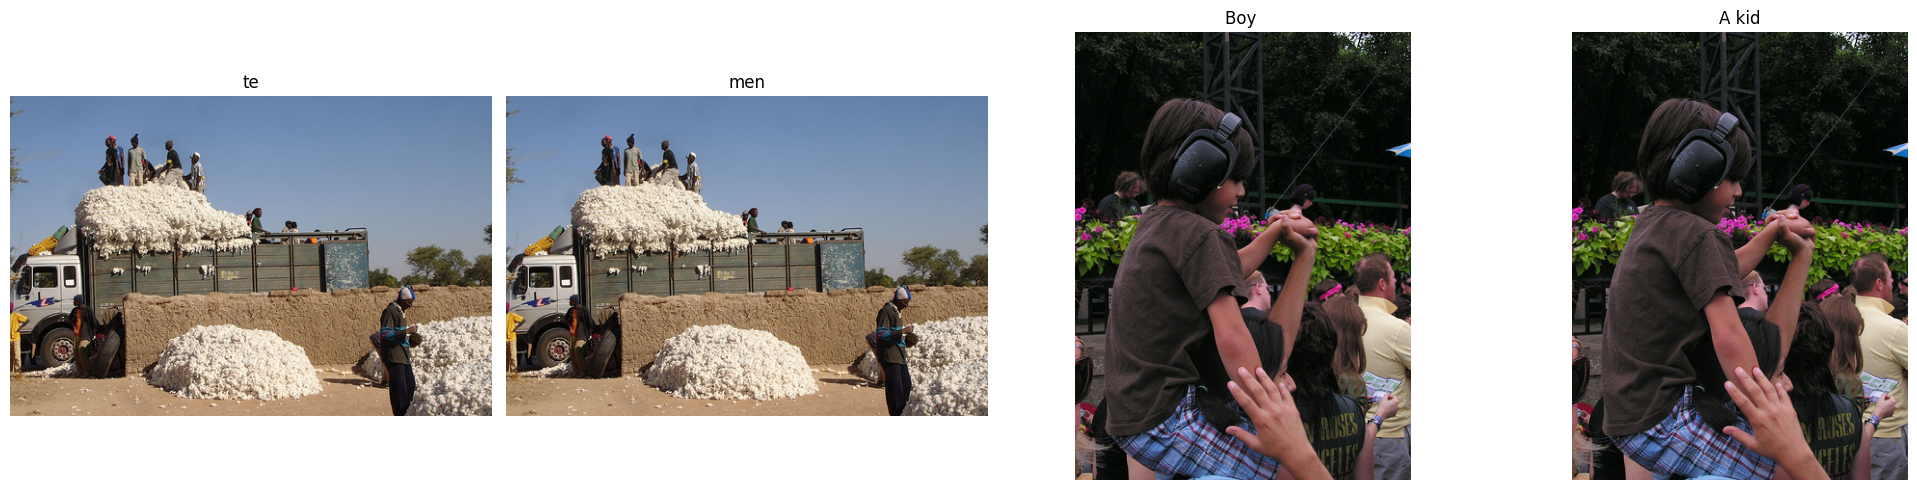

In [1277]:
fig, axes = plt.subplots(nrows = 1, ncols = len(df), figsize = (20,5))

for i,ax in enumerate(axes):
    image_data = ast.literal_eval(df['image'][i])
    image = Image.open(io.BytesIO(image_data['bytes']))

    caption_data = df['caption'][i]
    ax.imshow(image)
    ax.set_title(caption_data)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [1278]:
SOS = tokenizer.bos_id()
EOS = tokenizer.eos_id()

class DatasetClass(Dataset):
    def __init__(self, df, patch_size, image_size, max_seq_len):
        self.df = df
        self.patch_size = patch_size
        self.image_size = image_size
        self.max_seq_len = max_seq_len
        self.transform = transforms.Compose([transforms.Resize((image_size, image_size)),transforms.ToTensor()])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df["caption_tokens_ids"][idx]
        image = self.df["image"][idx]
        num_patches = int(self.image_size / self.patch_size)
        num_patches *= num_patches

        #image preprocessing
        image = ast.literal_eval(self.df['image'][idx])
        image = Image.open(io.BytesIO(image['bytes']))
        image = self.transform(image) #transforms the data and normalises also
        image = image.permute(1,2,0)
        height, width, _ = image.size()
        
        patches = []
        for i in range(0, width, self.patch_size):
            for j in range(0, height, self.patch_size):
                patch = image[i:i+self.patch_size, j:j+self.patch_size]
                patches.append(patch)

        patches = torch.stack(patches)
        # print(f"Patch shape - before = {patches.shape}")
        patches = patches.view(num_patches, -1)
        # print(f"Patch shape - after = {patches.shape}")
        # print("____________________________________________")
        
        #caption preprocessing
        input_caption = caption.copy()
        input_caption.insert(0, SOS)

        target_caption = caption.copy()
        target_caption.append(EOS)
        
        cap_len = len(input_caption)
        pad_len = self.max_seq_len - cap_len
        mask = []

        if pad_len > 0:
            zero_pad = [0] * pad_len
            input_caption.extend(zero_pad)
            input_caption_padded = input_caption
            target_caption.extend(zero_pad)
            target_caption_padded = target_caption
            mask.extend([1] * cap_len)
            mask.extend([0] * pad_len)
        else:
            input_caption_padded = input_caption[:self.max_seq_len]
            target_caption_padded = target_caption[:self.max_seq_len]
            mask.extend([1] * self.max_seq_len)

        return {
            'input_tokens' : torch.tensor(input_caption_padded),
            'target_tokens': torch.tensor(target_caption_padded),
            'mask'         : torch.tensor(mask),
            'patches'      : patches
                }

In [1279]:
image_size = 224
patch_size = 112
max_seq_len = 5
batch_sizes = 1
data = df

print(f"The patch size is {int((image_size/patch_size)**2)}")

dataset = DatasetClass(data, patch_size, image_size, max_seq_len)
dataloader = DataLoader(dataset, batch_size = batch_sizes)

for batch in dataloader:
    input_tokens, target_tokens, mask, patches  = batch['input_tokens'], batch['target_tokens'], batch['mask'], batch['patches']
    print("\n1st Batch data")
    print(f"\npatches size: {patches.size()}")
    print(f"\ninput_tokens: {input_tokens.shape}")
    print(input_tokens) 
    print(f"\ntarget_tokens: {target_tokens.shape}")
    print(target_tokens)
    print(f"\nmask shape : {mask.shape}")
    print(f"{mask}")
    break

The patch size is 4

1st Batch data

patches size: torch.Size([1, 4, 37632])

input_tokens: torch.Size([1, 5])
tensor([[ 1,  3, 10,  4,  0]])

target_tokens: torch.Size([1, 5])
tensor([[ 3, 10,  4,  2,  0]])

mask shape : torch.Size([1, 5])
tensor([[1, 1, 1, 1, 0]])


## Transformer Breakdown

In [1280]:
# encoder embedding
# decoder embedding
# Positional Encoding for encoder
# positional Encoding for decoder
# encoder
    # multi head attention
        # scaled dot product
    # normalisation
    # FF
    # normalisation
# FF for key, values
# decoder
    # masked multi head attention
        # scaled dot product
    # normalisation
    # cross multihead attention
        # scaled dot product
    # normalisation
    # FF
# FF and softmax
# Loss and bacpropagation

## Utility Functions

In [1281]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def scaled_dot_product(q, k, v, pad_mask=None, atn_mask=False):
    print(f"\n-----------SCALED DOT PRODUCT STARTS----------")
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    print(f"\nattention - q.kt are {scaled.shape}\n{scaled}")

    if atn_mask:
        dia_mask = torch.full(scaled.size(), float('-inf'))
        dia_mask = torch.triu(dia_mask, diagonal=1)
        print(f"\ndiagonal_mask is {dia_mask.shape}\n{dia_mask}")
        scaled += dia_mask
        print(f"\ndiagonal_mask applied {scaled.shape}\n{scaled}")
    attention = F.softmax(scaled, dim=-1)
    print(f"\nattention - after softmax are {attention.shape}\n{attention}")

    if pad_mask is not None:
        pad_mask = pad_mask.unsqueeze(1).unsqueeze(1) * pad_mask.unsqueeze(1).unsqueeze(3)
        print(f"\npad_mask is {pad_mask.shape}\n{pad_mask}")
        attention = attention.masked_fill(pad_mask==0, 0)
        print(f"\npad_mask is applied {attention.shape}\n{attention}")

    values = torch.matmul(attention, v)
    print(f"\nvalues - dot product - attention {values.shape}\n{values}")
    print(f"\n------------SCALED DOT PRODUCT ENDS----------")
    return values, attention


class PositionalEncoding(nn.Module):
    def __init__(self, max_sequence_length, d_model):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        print(f"\n------------POSITIONAL ENCODING STARTS----------")
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        print(f"\nPositional encoding values are {PE.shape}\n{PE}")
        print(f"\n------------POSITIONAL ENCODING ENDS----------")
        return PE
    

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, pad_mask=None, atn_mask=False):
        batch_size, sequence_length, d_model = x.shape
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv is {qkv.shape}\n{qkv}")
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, pad_mask, atn_mask = atn_mask)
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        print(f"\nFinal vlaues of attention block is {values.shape}\n{values}")
        return out

  
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        print(f"\nAfter normalization {out.shape}\n{out}")
        return out

## Encoder

In [1282]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        print(f"\nThe Positionwise feedforward is {x.shape}\n{x}")
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, pad_mask , atn_mask):
        residual_x = x
        print(f"\n----------ENCODER - MULTIHEAD ATTENTION STARTS------------")
        x = self.attention(x, pad_mask, atn_mask)
        print(f"\n----------ENCODER - MULTIHEAD ATTENTION ENDS------------")
        x = self.dropout1(x)
        print(f"\nFirst Residuals added {(x+residual_x).shape}\n{x+residual_x}")
        x = self.norm1(x + residual_x)
        residual_x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        print(f"\nSecond Residuals added {(x+residual_x).shape}\n{x+residual_x}")
        x = self.norm2(x + residual_x)
        return x
    

class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, pad_mask, atn_mask  = inputs
        for module in self._modules.values():
            x = module(x, pad_mask, atn_mask)
        return x


class Encoder(nn.Module):
    def __init__(self, 
                 d_model, 
                 ffn_hidden, 
                 num_heads, 
                 drop_prob, 
                 num_layers):
        super().__init__()
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, pad_mask = None, atn_mask = False):
        print("\n--------------ENCODER STARTS---------------")
        x = self.layers(x, pad_mask, atn_mask)
        print(f"\nimage encoder output {x.shape}\n{x}")
        print("\n--------------ENCODER ENDS---------------")
        return x

## Decoder

In [1283]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y):
        batch_size, patch_sizes, d_model = x.shape # in practice, this is the same for both languages...so we can technically combine with normal attention
        batch_size, sequence_length, d_model = y.shape
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, patch_sizes, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v) # We don't need the mask for cross attention, removing in outer function!
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out


class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, pad_mask, atn_mask):
        _y = y
        # print(f"y is {y.shape}")
        print(f"\n----------DECODER - MASKED - MULTIHEAD ATTENTION STARTS------------")
        y = self.self_attention(y, pad_mask, atn_mask)
        print(f"\n----------DECODER - MASKED - MULTIHEAD ATTENTION ENDS------------")
        y = self.dropout1(y)
        print(f"\nFirst Residuals added {(y+_y).shape}\n{y+_y}")
        y = self.norm1(y + _y) 
        _y = y
        print(f"\n----------DECODER - CROSS MULTIHEAD ATTENTION STARTS------------")
        y = self.encoder_decoder_attention(x, y)
        print(f"\n----------DECODER - CROSS MULTIHEAD ATTENTION ENDS------------")       
        y = self.dropout2(y)
        print(f"\nSecond Residuals added {(y+_y).shape}\n{y+_y}")
        y = self.norm2(y + _y)
        _y = y  
        y = self.ffn(y) 
        y = self.dropout3(y)
        print(f"\nThird Residuals added {(y+_y).shape}\n{y+_y}")
        y = self.norm3(y + _y) 
        return y
    

class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, pad_mask, atn_mask = inputs
        for module in self._modules.values():
            y = module(x, y, pad_mask, atn_mask)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 d_model, 
                 ffn_hidden, 
                 num_heads, 
                 drop_prob, 
                 num_layers,
                 max_sequence_length):
        super().__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, pad_mask = None, atn_mask = True):
        print("\n--------------DECODER STARTS---------------")
        y = self.layers(x, y, pad_mask, atn_mask)
        print(f"\n decoder output is {y.shape}\n{y}")
        print("\n--------------DECODER ENDS---------------")
        return y

# Transformer

In [1284]:
class Transformer(nn.Module):
    def __init__(self, 
                d_model, 
                ffn_hidden, 
                num_heads, 
                drop_prob, 
                num_layers,
                max_sequence_length,
                vocab_size,
                num_patches,
                pixels
                ):
        super().__init__()
        self.d_model = d_model
        self.num_patches = num_patches
        self.max_sequence_length = max_sequence_length #5
        self.pixels = pixels
        self.vocab_size = vocab_size
        self.enc_embedding = nn.Linear(pixels, d_model)
        self.enc_pos_encoding = PositionalEncoding(num_patches, d_model)
        self.dec_embedding = nn.Embedding(vocab_size, d_model)
        self.dec_pos_encoding = PositionalEncoding(max_sequence_length, d_model) # redefined inside the forward function to inference purpose
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length)
        self.linear = nn.Linear(d_model, vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self, 
                patches, 
                input_tokens,
                pad_mask=None, 
                atn_mask=True,
                ):
        
        # Image
        print("\n---------------TRANSFORMER STARTS------------")
        patch_embeddings = self.enc_embedding(patches)
        print(f"\nimage patch_embeddings is {patch_embeddings.shape}\n{patch_embeddings}")
        patch_pos_encodings = self.enc_pos_encoding()
        patch_embeddings_with_pos = patch_embeddings + patch_pos_encodings.unsqueeze(0)
        print(f"\nimage embedding + Positional {patch_embeddings_with_pos.shape}\n{patch_embeddings_with_pos}")
        x = self.encoder(patch_embeddings_with_pos)
        
        # Token
        token_embeddings = self.dec_embedding(input_tokens)
        print(f"\ntoken_embeddings is {token_embeddings.shape}\n{token_embeddings}")
        max_sequence_length = token_embeddings.shape[1]
        # print(f"max_sequence_length is ---------------------------------------------{max_sequence_length}")
        self.dec_pos_encoding = PositionalEncoding(max_sequence_length, self.d_model)
        token_pos_encodings = self.dec_pos_encoding()
        token_embeddings_with_pos = token_embeddings + token_pos_encodings.unsqueeze(0) 
        print(f"\ntoken embedding + Positional{token_embeddings_with_pos.shape}\n{token_embeddings_with_pos}")
        out = self.decoder(x, token_embeddings_with_pos, pad_mask, atn_mask)
        out = self.linear(out)
        print(f"\nFinal output is {out.shape}\n{out}")
        print("\n--------------- TRANSFORMER ENDS------------")
        return out


## Instantiation

In [1285]:
d_model = 6 #make sure it is even always, as we are using only the ven denokinators in postional encoding
num_heads = 1 # divisible by d_model
drop_prob = 0.1
ffn_hidden = 128
num_layers = 1
num_patches = int((image_size/patch_size)**2)
num_epochs = 1

batch_size = batch_sizes
vocab_size = vocab_size
max_sequence_length = max_seq_len
pixels = patches.shape[-1]
# print(pixels)

transformer = Transformer(d_model, 
                          ffn_hidden,
                          num_heads, 
                          drop_prob, 
                          num_layers, 
                          max_sequence_length, 
                          vocab_size, 
                          num_patches, 
                          pixels)

optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

In [1286]:
print(transformer)

Transformer(
  (enc_embedding): Linear(in_features=37632, out_features=6, bias=True)
  (enc_pos_encoding): PositionalEncoding()
  (dec_embedding): Embedding(15, 6)
  (dec_pos_encoding): PositionalEncoding()
  (encoder): Encoder(
    (layers): SequentialEncoder(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (qkv_layer): Linear(in_features=6, out_features=18, bias=True)
          (linear_layer): Linear(in_features=6, out_features=6, bias=True)
        )
        (norm1): LayerNormalization()
        (dropout1): Dropout(p=0.1, inplace=False)
        (ffn): PositionwiseFeedForward(
          (linear1): Linear(in_features=6, out_features=128, bias=True)
          (linear2): Linear(in_features=128, out_features=6, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNormalization()
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (layers): SequentialDeco

## Training

In [1287]:
for epoch in range(num_epochs):
    print("\n------------------EPOCH STARTS------------------")
    iterator = iter(dataloader)
    progress_bar = tqdm(iterator, total=len(iterator), desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_num, batch in enumerate(progress_bar):
        transformer.train()
        input_tokens, target_tokens, pad_mask, patches = batch['input_tokens'], batch['target_tokens'], batch['mask'], batch['patches']
        print(f"\ninput_tokens, pad_mask, patches \n{input_tokens.shape, pad_mask.shape, patches.shape}")
        optimizer.zero_grad()
        predictions = transformer(patches, input_tokens, pad_mask)
        loss = criterion(predictions.view(-1, vocab_size), target_tokens.view(-1))
        # loss = loss.sum()
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        print("\n------------------EPOCH ENDS------------------")


------------------EPOCH STARTS------------------


Epoch 1/1:  25%|██▌       | 1/4 [00:00<00:00,  8.86it/s, loss=2.7675]


input_tokens, pad_mask, patches 
(torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([1, 4, 37632]))

---------------TRANSFORMER STARTS------------

image patch_embeddings is torch.Size([1, 4, 6])
tensor([[[ 0.4180,  0.2652,  0.3966,  0.1219,  0.5833,  0.0617],
         [ 0.4254,  0.3049,  0.2785,  0.0948,  0.4638,  0.1973],
         [ 0.1561,  0.1624,  0.3875,  0.0205,  0.3647, -0.0711],
         [ 0.3164,  0.4841,  0.3237, -0.0683,  0.4636, -0.0439]]],
       grad_fn=<ViewBackward0>)

------------POSITIONAL ENCODING STARTS----------

Positional encoding values are torch.Size([4, 6])
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000]])

------------POSITIONAL ENCODING ENDS----------

image embedding + Positional torch.Size([1, 4, 6])
tensor([[[ 0.4180,  1.2652,  0.3966,  1.1219,  0.5

Epoch 1/1:  50%|█████     | 2/4 [00:00<00:00,  9.44it/s, loss=2.7178]


The Positionwise feedforward is torch.Size([1, 5, 6])
tensor([[[-0.0384,  0.0369,  0.3581,  0.1288, -0.5828,  0.3647],
         [-0.0473,  0.0258,  0.4399,  0.4595, -0.3758,  0.5699],
         [-0.1027, -0.3640,  0.1681,  0.5169, -0.3260, -0.1313],
         [-0.0076,  0.0274,  0.1242,  0.4133, -0.0953,  0.1700],
         [ 0.2870,  0.3122,  0.1944,  0.0900,  0.0398,  0.2178]]],
       grad_fn=<ViewBackward0>)

Third Residuals added torch.Size([1, 5, 6])
tensor([[[-0.9220,  2.0595, -0.2815,  0.3685, -1.4403,  0.5126],
         [ 0.3877,  0.4696, -0.6938,  1.6772, -1.9564,  1.3595],
         [ 0.3723, -1.5289,  0.7866,  0.9227, -1.9260,  1.1079],
         [-0.4814, -1.5191, -0.4886,  1.2267,  0.1225,  1.3829],
         [-1.7680,  0.9164,  0.0892, -0.5409,  1.2389,  0.6667]]],
       grad_fn=<AddBackward0>)

After normalization torch.Size([1, 5, 6])
tensor([[[-0.8615,  1.7825, -0.2935,  0.2829, -1.3211,  0.4107],
         [ 0.1466,  0.2132, -0.7324,  1.1947, -1.7585,  0.9364],
         [

Epoch 1/1:  50%|█████     | 2/4 [00:00<00:00,  9.44it/s, loss=2.9609]


input_tokens, pad_mask, patches 
(torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([1, 4, 37632]))

---------------TRANSFORMER STARTS------------

image patch_embeddings is torch.Size([1, 4, 6])
tensor([[[ 0.0177, -0.0652,  0.0670, -0.0979,  0.0548,  0.0284],
         [-0.0201,  0.0480,  0.0387, -0.0708,  0.0180, -0.0791],
         [ 0.1814,  0.0636, -0.0119,  0.1565,  0.1034, -0.0664],
         [ 0.1011,  0.1476,  0.0496, -0.1451,  0.2650, -0.1140]]],
       grad_fn=<ViewBackward0>)

------------POSITIONAL ENCODING STARTS----------

Positional encoding values are torch.Size([4, 6])
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000]])

------------POSITIONAL ENCODING ENDS----------

image embedding + Positional torch.Size([1, 4, 6])
tensor([[[ 0.0177,  0.9348,  0.0670,  0.9021,  0.0

Epoch 1/1: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s, loss=2.7176]



------------------EPOCH ENDS------------------


In [1288]:
# Save the model and its weights
torch.save({
    'model_state_dict': transformer.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "small_model.pth")

In [1289]:
# Later, when you want to load the model and optimizer state
loaded_transformer = Transformer(d_model, 
                          ffn_hidden,
                          num_heads, 
                          drop_prob, 
                          num_layers, 
                          max_sequence_length, 
                          vocab_size, 
                          num_patches, 
                          pixels)
checkpoint = torch.load("small_model.pth")
loaded_transformer.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [1290]:
for epoch in range(num_epochs):
    iterator = iter(dataloader)
    progress_bar = tqdm(iterator, total=len(iterator), desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_num, batch in enumerate(progress_bar):
        loaded_transformer.train() # change to loaded_transformer
        input_tokens, target_tokens, pad_mask, patches = batch['input_tokens'], batch['target_tokens'], batch['mask'], batch['patches']
        optimizer.zero_grad()
        predictions = loaded_transformer(patches, input_tokens, pad_mask) #change to loaded_transformer
        loss = criterion(predictions.view(-1, vocab_size), target_tokens.view(-1))
        print(f"Loss : {loss}")
        # loss = loss.sum()
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=f"{loss.item():.8f}")

Epoch 1/1:  50%|█████     | 2/4 [00:00<00:00, 11.72it/s, loss=2.74080467]


---------------TRANSFORMER STARTS------------

image patch_embeddings is torch.Size([1, 4, 6])
tensor([[[ 0.3445,  0.3400,  0.4015,  0.1542,  0.5510, -0.0126],
         [ 0.3531,  0.3786,  0.2849,  0.1311,  0.4289,  0.1243],
         [ 0.0973,  0.2223,  0.4020,  0.0531,  0.3338, -0.1304],
         [ 0.2529,  0.5489,  0.3387, -0.0336,  0.4312, -0.1081]]],
       grad_fn=<ViewBackward0>)

------------POSITIONAL ENCODING STARTS----------

Positional encoding values are torch.Size([4, 6])
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000]])

------------POSITIONAL ENCODING ENDS----------

image embedding + Positional torch.Size([1, 4, 6])
tensor([[[ 0.3445,  1.3400,  0.4015,  1.1542,  0.5510,  0.9874],
         [ 1.1945,  0.9189,  0.3313,  1.1300,  0.4311,  1.1243],
         [ 1.0066, -0.

Epoch 1/1: 100%|██████████| 4/4 [00:00<00:00, 11.51it/s, loss=2.68201971]


Positional encoding values are torch.Size([5, 6])
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000]])

------------POSITIONAL ENCODING ENDS----------

token embedding + Positionaltorch.Size([1, 5, 6])
tensor([[[ 0.1750,  3.0672, -0.1287,  1.3319,  0.3037,  1.0658],
         [ 1.4570,  1.6179, -1.5622,  2.5519, -1.5767,  1.7198],
         [-0.1277, -1.4530, -0.9629,  0.7843, -0.5815,  2.0528],
         [ 0.6129, -1.1809,  0.1447,  1.7929, -0.5423,  1.5170],
         [-0.6866, -2.1729,  1.2628, -0.7380, -0.0146,  1.2013]]],
       grad_fn=<AddBackward0>)

--------------DECODER STARTS---------------

----------DECODER - MASKED - MULTIHEAD ATTENTION STARTS------------
qkv is torch.Size([1, 1, 5, 18])
tensor([[[[ 0.0751, -0.4

## Inference

In [1291]:
def load_and_preprocess_image(img_path, patch_size, image_size):
    # Load the image
    image = Image.open(img_path).convert('RGB')
    # Resize and normalize the image
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    image = transform(image)
    # print(f"The shape of imaeg is {image.shape}")

    # Extract patches
    patches = []
    for i in range(0, image_size, patch_size):
        for j in range(0, image_size, patch_size):
            patch = image[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)

    patches = torch.stack(patches)
    # print(f"Patch size befere {patches.shape}")
    patches = patches.view(-1, patch_size*patch_size*3)  # Flatten the patches
    
    return patches

def generate_caption(transformer, img_path, vocab_size, patch_size, image_size):
    # Load and preprocess the image
    patches = load_and_preprocess_image(img_path, patch_size, image_size)
    patches = patches.unsqueeze(0)  # Add a batch dimension
    print(f"Patch size after {patches.shape}")
    
    # Initial tokens (assuming the tokenizer and other utilities are defined globally)
    input_tokens = torch.tensor([[tokenizer.bos_id()]], dtype=torch.long)
    print(f"input_tokens is {input_tokens, input_tokens.shape}")
    # print(f"max_seq_len {max_seq_len}")
    print(f"\ntokenizer.eos_id() is {tokenizer.eos_id()}")
    
    generated_caption = []
    print(f"\ninitial generated_caption is {generated_caption}")
    while len(generated_caption) < max_seq_len:
        # Prepare masks for padding (not shown here for simplicity)
        pred = transformer(patches, input_tokens)
        print(f"\nPredicted output  is ------ {pred.shape}")
        pred_idx = pred[:, -1, :].argmax(dim=-1).item()  # Predict the next word
        print(f"\nPredicted index is ------ {pred_idx}")

        if pred_idx == tokenizer.eos_id():
            print("\n EOS token detected")
            break

        generated_caption.append(pred_idx)
        print(f"\nUpdated generated_caption is {generated_caption}")
        input_tokens = torch.cat([input_tokens, torch.tensor([[pred_idx]], dtype=torch.long)], dim=-1)
        print(f"\nUpdated input token is {input_tokens}")
    print(f"\n-------ALL WORDS GENERATED--------")
    captions = tokenizer.decode_ids(generated_caption)
    # print(f"caption is {(captions)}")
    return captions

# Example usage
img_path = "image.jpg"
# print(f"patch_size is {patch_size}")
predicted_caption = generate_caption(loaded_transformer, img_path, vocab_size, patch_size, image_size)
print("Predicted Caption:", predicted_caption)


Patch size after torch.Size([1, 4, 37632])
input_tokens is (tensor([[1]]), torch.Size([1, 1]))

tokenizer.eos_id() is 2

initial generated_caption is []

---------------TRANSFORMER STARTS------------

image patch_embeddings is torch.Size([1, 4, 6])
tensor([[[ 0.2474,  0.1771,  0.2150,  0.1179,  0.2394, -0.0346],
         [ 0.3801,  0.0397,  0.2501,  0.0734,  0.1018,  0.0852],
         [ 0.0298,  0.3449,  0.0786, -0.1195,  0.1191, -0.0007],
         [ 0.1669,  0.3881, -0.0952,  0.0540,  0.0866,  0.0729]]],
       grad_fn=<ViewBackward0>)

------------POSITIONAL ENCODING STARTS----------

Positional encoding values are torch.Size([4, 6])
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000]])

------------POSITIONAL ENCODING ENDS----------

image embedding + Positional torch.Size([1, 4, 6])